<a href="https://colab.research.google.com/github/perfectism13/learning_colab/blob/master/Analysis_video_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 环境配置和模型导入

In [11]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir(r'/content/drive/My Drive/colab/mlnd_distracted_driver_detection/state-farm-distracted-driver-detection/imgs/')
print(os.getcwd())
!ls
!pip install keras==2.1.5
import keras
print(keras.__version__)
!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/colab/mlnd_distracted_driver_detection/state-farm-distracted-driver-detection/imgs
'(1-726)clean.mp4'      driver_imgs_list_right.csv   sample_submission.csv
'(1-726).mp4'	        my_model10.h5		     test
'（726-800)clean.mp4'   my_model11.h5		     train
 （726-800）.mp4        my_model12.h5		     valid
'(726-966)clean.mp4'    my_model13.h5		     vect
'(726-966).mp4'         my_model1.h5		     video_model_change_vd.h5
 driver_imgs_list.csv   my_model9.h5		     video_model.h5
2.1.5
Thu Feb  6 15:45:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp 

In [0]:
import os
os.environ['KERAS_BACKEND']='tensorflow'
import keras

In [0]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random

#seed
np.random.seed(2017)
from keras.models import *
from keras.layers.convolutional import Conv2D
from keras.applications import *

In [0]:
model = load_model('video_model.h5')

In [15]:
model.summary()
len(model.layers)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 5)  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 297, 297, 3)  138         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 297, 297, 3)  12          conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 297, 297, 3)  0           batch_normalization_42[0][0]     
__________________________________________________________________________________________________
conv2d_9 (

138

##get_im_cv2函数

In [0]:
# Load a preprocessed image
def get_im_cv2(path, img_size):
    img = cv2.imread(path)
    img = np.array(img, dtype=np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # reduce size
    img = cv2.resize(img, (img_size, img_size))
    # normalization
    img /= 127.5
    img -= 1.
    #print (img[1:5, 1:5, 0])
    return img

##获取两帧图片间的光流

In [0]:
# -*- coding: utf-8 -*-
import cv2
import numpy as np

def get_mffs(path1,path2):
  frame1 = cv2.imread(path1)
  frame1 = cv2.resize(frame1, (299, 299))
  prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
  hsv = np.zeros_like(frame1)
  hsv[...,1] = 255
  frame2 = cv2.imread(path2)
  frame2 = cv2.resize(frame2, (299, 299))
  next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
  flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
  mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
  hsv[...,0] = ang*180/np.pi/2
  hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
  rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
  data = np.zeros((299, 299,5))
  data[:, :, 0] = frame1[:, :, 0]
  data[:, :, 1] = frame1[:, :, 1]
  data[:, :, 2] = hsv[:, :, 0]
  data[:, :, 2] = hsv[:, :, 2]
  return data

##查看前199张图片的预测结果

In [8]:
index = os.path.join('.', 'driver_imgs_list.csv')
#以只读方式打开该文件
f = open(index, 'r')
lines = f.readlines()
print(len(lines))

22425


In [7]:
index = os.path.join('.', 'driver_imgs_list.csv')
#以只读方式打开该文件
f = open(index, 'r')
lines = f.readlines()

class_list = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
error = []
right = []

for i in range(400):
    arr1 = lines[i+1].strip().split(',')
    arr2 = lines[i+2].strip().split(',')
    p = os.path.join('.', 'train', arr1[1], arr1[2])
    p1 = os.path.join('.', 'train', arr2[1], arr2[2])
    predictions = model.predict(np.expand_dims(get_mffs(p,p1), axis=0))
    predictions = predictions[0]    
    pred_idx = np.argmax(predictions)
    #print (class_list[pred_idx], arr[1])
    if class_list[pred_idx] != arr1[1]:
        error.append(arr1[2])
    else :
      right.append(arr1[2])    
print (error)
print(len(error),len(right))

['img_66355.jpg', 'img_29321.jpg']
2 398


##对整个Train_set的22425张照片预测

In [0]:
index = os.path.join('.', 'driver_imgs_list.csv')
#以只读方式打开该文件
f = open(index, 'r')
lines = f.readlines()
class_list = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
error = {"c0":0,"c1":0,"c2":0,"c3":0,"c4":0,"c5":0,"c6":0,"c7":0,"c8":0,"c9":0}
right = {"c0":0,"c1":0,"c2":0,"c3":0,"c4":0,"c5":0,"c6":0,"c7":0,"c8":0,"c9":0}
# for i in range(10):
#   k = 'c{class}'.format(class=i)
#   error[k]

print(error,right)
for i in range(22424):
    arr1 = lines[i+1].strip().split(',')
    arr2 = lines[i+2].strip().split(',')
    p = os.path.join('.', 'train', arr1[1], arr1[2])
    p1 = os.path.join('.', 'train', arr2[1], arr2[2])
    predictions = model.predict(np.expand_dims(get_mffs(p,p1), axis=0))
    # predictions1 = model1.predict(np.expand_dims(get_im_cv2(p,224), axis=0))
    # predictions2 = model2.predict(np.expand_dims(get_im_cv2(p,299), axis=0))
    # predictions3 = model3.predict(np.expand_dims(get_im_cv2(p,299), axis=0))
    # predictions = 0.25*(predictions+predictions1+predictions2+predictions3)
    predictions = predictions[0]    
    pred_idx = np.argmax(predictions)
    #print (class_list[pred_idx], arr[1])
    if class_list[pred_idx] != arr1[1]:
        error[arr1[1]]+=1
    else :
      right[arr1[1]]+=1    
# print (error)
print(error,right)
# print(len(error),len(right))
for i in range(10):
  print(right[class_list[i]]/(right[class_list[i]]+error[class_list[i]]))

{'c0': 0, 'c1': 0, 'c2': 0, 'c3': 0, 'c4': 0, 'c5': 0, 'c6': 0, 'c7': 0, 'c8': 0, 'c9': 0} {'c0': 0, 'c1': 0, 'c2': 0, 'c3': 0, 'c4': 0, 'c5': 0, 'c6': 0, 'c7': 0, 'c8': 0, 'c9': 0}


# 读取图片并展示

##训练集预测错误图片


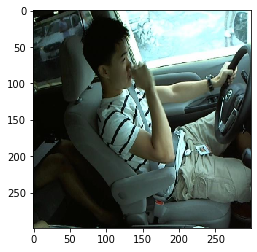

In [0]:
%matplotlib inline
path1 = os.path.join('.', 'train', 'c0', 'img_66355.jpg')

plt.imshow((get_im_cv2(path1, 299)+1)/2)

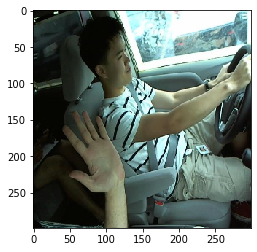

In [0]:
%matplotlib inline
path2 = os.path.join('.', 'train', 'c0', 'img_29321.jpg')

plt.imshow((get_im_cv2(path2, 299)+1)/2)

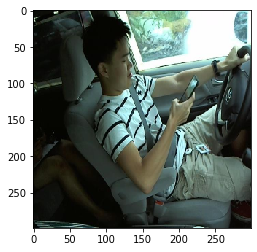

In [0]:
%matplotlib inline
path3 = os.path.join('.', 'train', 'c1', 'img_16856.jpg')

plt.imshow((get_im_cv2(path3, 299)+1)/2)

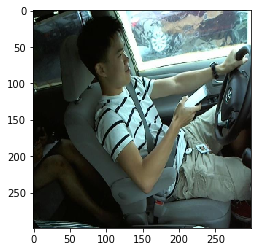

In [0]:
%matplotlib inline
path4 = os.path.join('.', 'train', 'c1', 'img_4562.jpg')

plt.imshow((get_im_cv2(path4, 299)+1)/2)

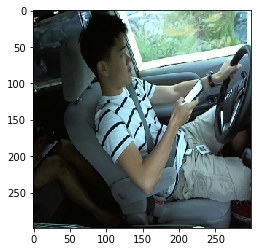

In [0]:
%matplotlib inline
path5 = os.path.join('.', 'train', 'c1', 'img_11478.jpg')

plt.imshow((get_im_cv2(path5, 299)+1)/2)

##训练集正确图片演示

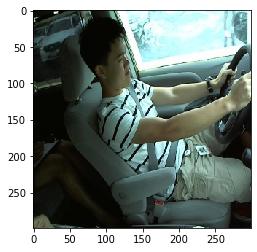

In [0]:
%matplotlib inline
path_r0 = os.path.join('.', 'train', 'c0', 'img_5585.jpg')

plt.imshow((get_im_cv2(path_r0, 299)+1)/2)

In [0]:
path_r1 = os.path.join('.', 'train', 'c1', 'img_6329.jpg')
path_r2 = os.path.join('.', 'train', 'c2', 'img_79978.jpg')
path_r3 = os.path.join('.', 'train', 'c3', 'img_42080.jpg')
path_r4 = os.path.join('.', 'train', 'c4', 'img_93900.jpg')
path_r5 = os.path.join('.', 'train', 'c5', 'img_59763.jpg')
path_r8 = os.path.join('.', 'train', 'c8', 'img_86743.jpg')
path_r9 = os.path.join('.', 'train', 'c9', 'img_3484.jpg')

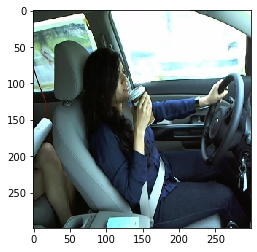

In [0]:
%matplotlib inline
path_r6 = os.path.join('.', 'train', 'c6', 'img_20138.jpg')

plt.imshow((get_im_cv2(path_r6, 299)+1)/2)

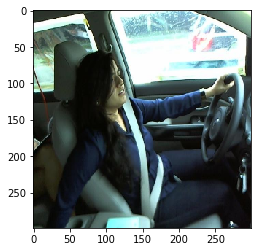

In [0]:
%matplotlib inline
path_r7 = os.path.join('.', 'train', 'c7', 'img_82196.jpg')

plt.imshow((get_im_cv2(path_r7, 299)+1)/2)

##测试集图片演示

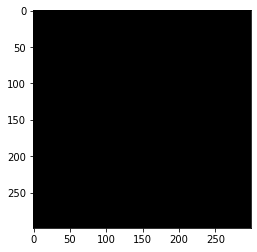

In [0]:
%matplotlib inline
# path6 = os.path.join('.', 'test',  'img_1.jpg')
path_t = os.path.join('.', 'test','test','img_34017.jpg')
plt.imshow((get_im_cv2(path_t, 299)+1)/2)

##演示左右拼接


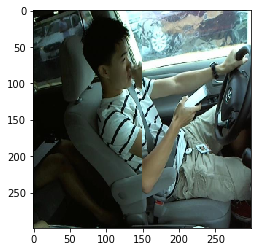

In [0]:
# concatenate two images
img = get_im_cv2(path1, 299)
img2 = get_im_cv2(path4, 299)
left = img[:, :150, :]
right = img2[:, 150:, :]
img1 = np.concatenate((left, right), axis=1)
%matplotlib inline
plt.imshow((img1+1)/2)

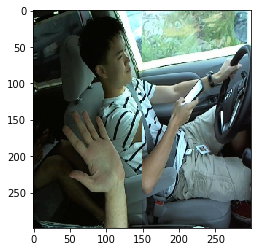

In [0]:
# concatenate two images
img = get_im_cv2(path2, 299)
img2 = get_im_cv2(path5, 299)
left = img[:, :150, :]
right = img2[:, 150:, :]
img2 = np.concatenate((left, right), axis=1)
%matplotlib inline
plt.imshow((img2+1)/2)

# CAM可视化

##函数编写


In [0]:
# the model to get the feature map
model_cnn = Model(model.input, model.layers[131].output, name='xception')

# the model to get cam
inputs = Input((299, 299, 3))
x = inputs
x = model_cnn(x)
cam = Conv2D(10, 1, use_bias=False, name='cam')(x)
model_cam = Model(inputs, cam)

# set the weight of last layer
weights = model.layers[134].get_weights()[0]
#print (np.shape(weights))
model_cam.layers[-1].set_weights([weights.reshape((1,1,2048,10))])


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def show_cam(image):
    status = ["safe driving",  " texting - right",  "phone - right",  "texting - left",  "phone - left",  
                  "operation radio", "drinking", "reaching behind", "hair and makeup", "talking"]
    plt.figure()
    predictions = model.predict(np.expand_dims(image, axis=0))
    predictions = predictions[0]    
    pred_idx = np.argmax(predictions)
    pred = status[pred_idx]
    prediction = predictions[pred_idx]

    plt.title('Pred: %s %.2f%%' % (pred, prediction*100))
    
    cam = model_cam.predict(np.expand_dims(image, axis=0))
    cam = cam[0,:,:,pred_idx]
    cam -= cam.min()
    cam /= cam.max()
    cam = cv2.resize(cam, (299, 299))
    cam[cam<0] = 0
    cam[cam>1] = 1
    cam = np.uint8(255*cam)

    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

    out = cv2.addWeighted(np.uint8((image+1)/2*255), 0.6, heatmap, 0.4, 0)

    plt.axis('off')
    plt.imshow(out)

##训练集错误图片可视化


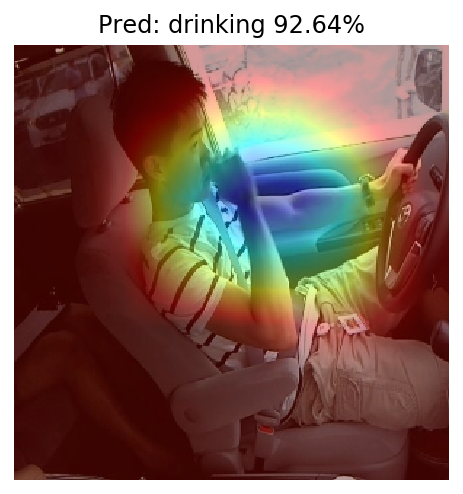

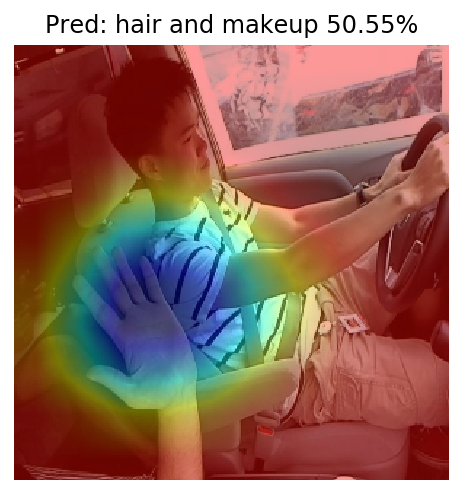

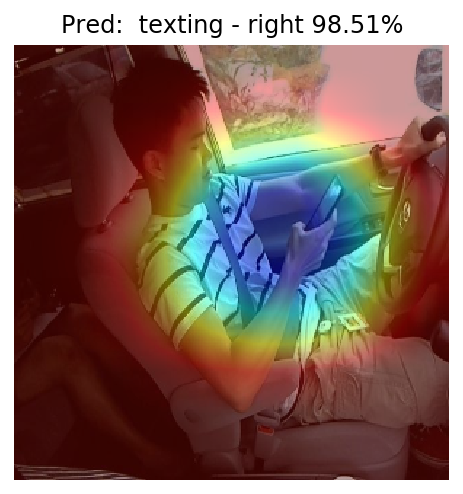

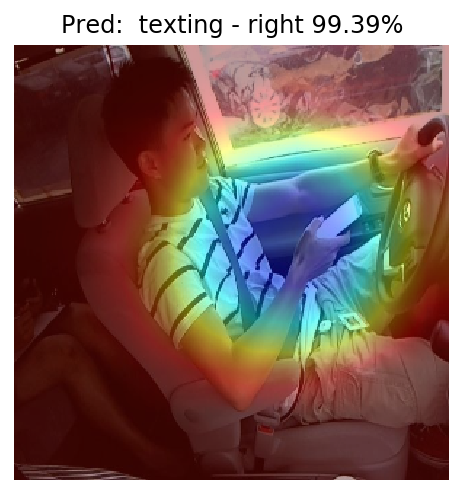

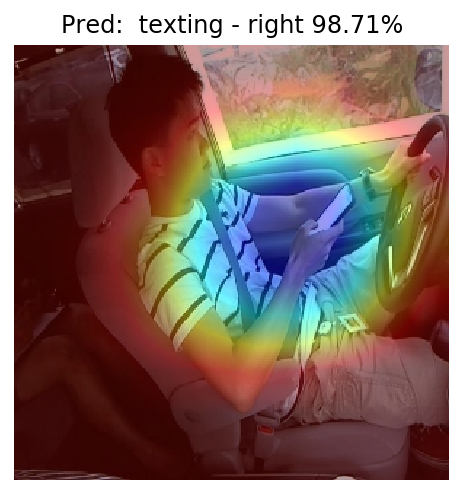

In [0]:
show_cam(get_im_cv2(path1, 299))
show_cam(get_im_cv2(path2, 299))
show_cam(get_im_cv2(path3, 299))
show_cam(get_im_cv2(path4, 299))
show_cam(get_im_cv2(path5, 299))

##预测左右拼接图片

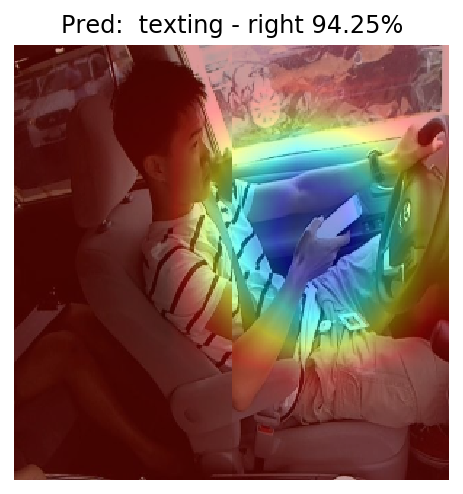

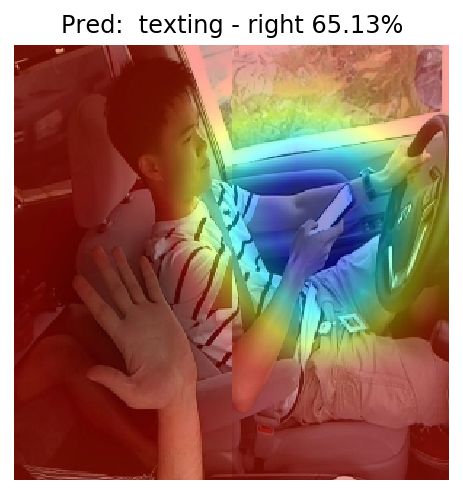

In [0]:
show_cam(img1)
show_cam(img2)

##训练集正确图片可视化


In [0]:
show_cam(get_im_cv2(path_r1, 299))
show_cam(get_im_cv2(path_r2, 299))
show_cam(get_im_cv2(path_r3, 299))
show_cam(get_im_cv2(path_r0, 299))
show_cam(get_im_cv2(path_r4, 299))
show_cam(get_im_cv2(path_r5, 299))
show_cam(get_im_cv2(path_r6, 299))
show_cam(get_im_cv2(path_r7, 299))
show_cam(get_im_cv2(path_r8, 299))
show_cam(get_im_cv2(path_r9, 299))

##测试集图片可视化


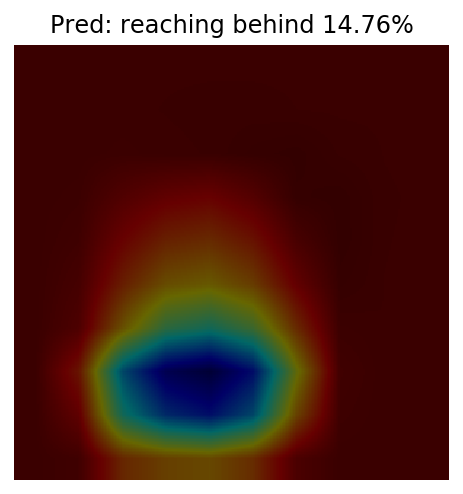

In [0]:
show_cam(get_im_cv2(path_t, 299))